# Applying Image Processing Filters For Image Cartoonifying


# libraries

In [ ]:
import cv2
import numpy as np
from IPython.display import Image as dis
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load the image

In [ ]:
image = cv2.imread('part1.jpg')

#Noise Reduction Using Median Filter

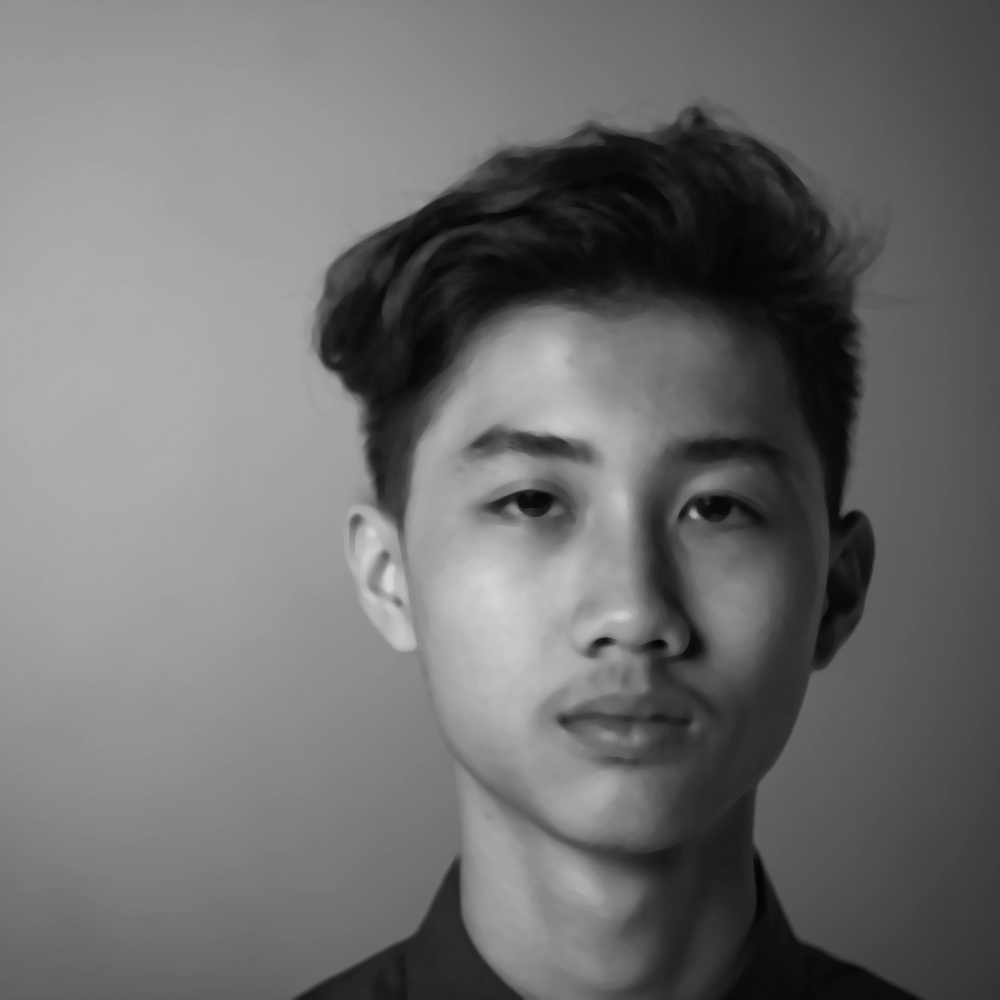

In [ ]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Choose the kernel size for the median filter (e.g., 3x3)
kernel_size = 9
median_filtered = cv2.medianBlur(gray_image, kernel_size)

cv2.imwrite('grayscale_median_filtered_image.jpg', median_filtered)

# Display the image
dis('grayscale_median_filtered_image.jpg')


#Edge Detection Using Laplacian Filter

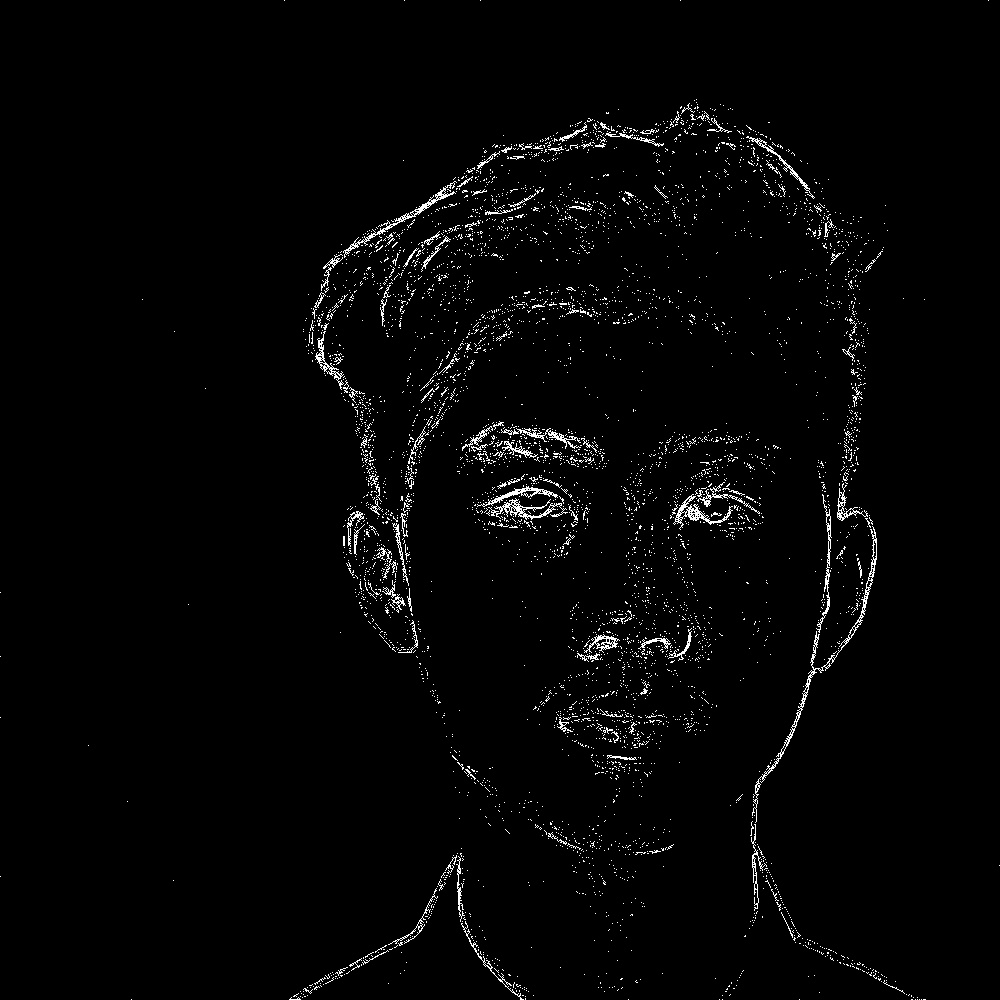

In [ ]:
# Apply the Laplacian filter for edge detection
laplacian = cv2.Laplacian(median_filtered, cv2.CV_64F)

# Convert the result to the absolute value
laplacian_abs = np.absolute(laplacian)
laplacian_uint8 = np.uint8(laplacian_abs)
# Apply a binary threshold to create a sketch-like effect
threshold_value = 5  # Adjust this value to control the threshold
ret, binary_sketch = cv2.threshold(laplacian_uint8, threshold_value, 255, cv2.THRESH_BINARY)

# Save the resulting sketch-like image
cv2.imwrite('sketch_image.jpg', binary_sketch)

# Display the image
dis('sketch_image.jpg')

#Generating a color painting and a cartoon






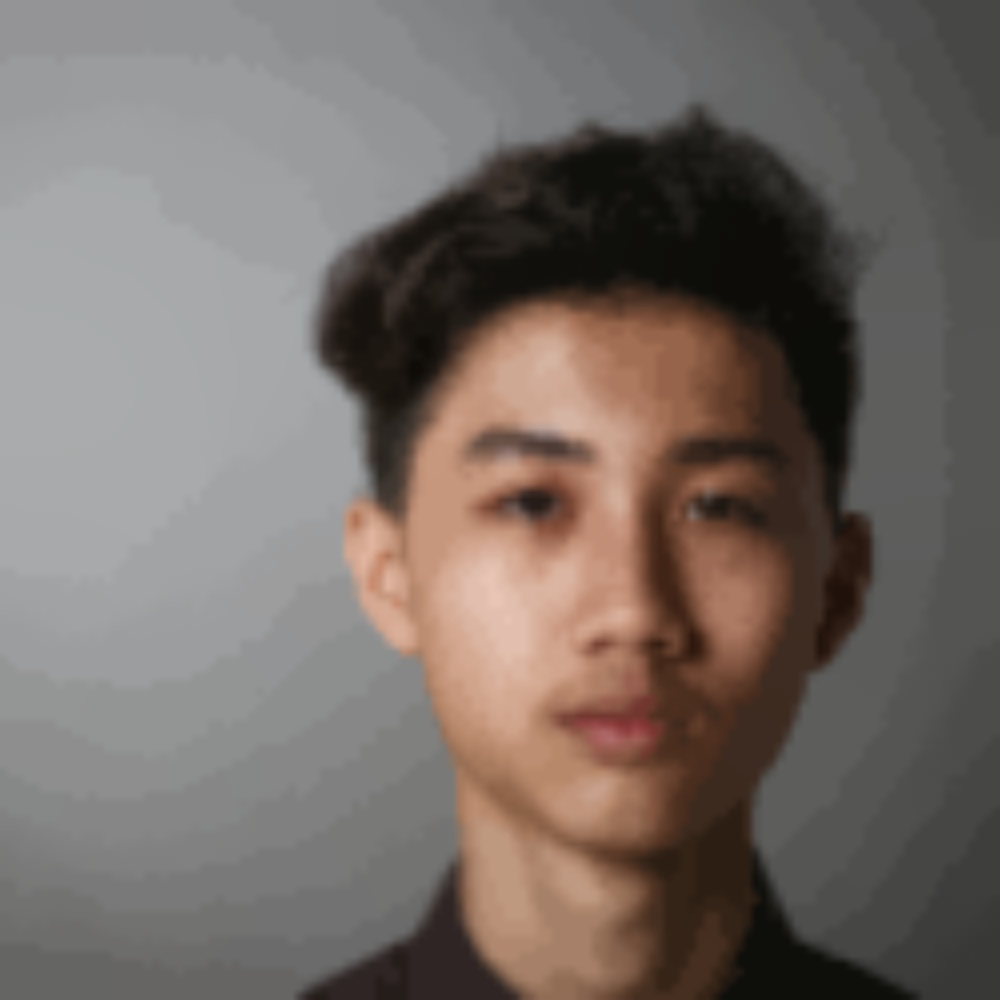

In [ ]:
def cartoonize_image(img, color_strength, positional_strength, size, repetitions):

    # Perform a series of bilateral filtering to create a cartoon effect
    for _ in range(repetitions):
        # Downscale the image for faster processing
        img_small = cv2.resize(img, None, fx=1/8, fy=1/8)

        # Apply bilateral filter with truncated filter size
        img_small = cv2.bilateralFilter(img_small, size, color_strength, positional_strength)

        # Upscale the image back to the original size
        img = cv2.resize(img_small, (img.shape[1], img.shape[0]))

    return img

# Parameters for the cartoon effect
color_strength = 5  # Controls color filtering
positional_strength = 10  # Controls edge preservation
size = 20  # Truncated filter size
repetitions = 10  # Number of repetitions for the cartoon effect

# Generate the cartoon-like image
cartoon_image = cartoonize_image(image, color_strength, positional_strength, size, repetitions)


# Save the resulting cartoon image
cv2.imwrite('cartoon_image.jpg', cartoon_image)

# Display the image
dis('cartoon_image.jpg')

#overlay the edge mask

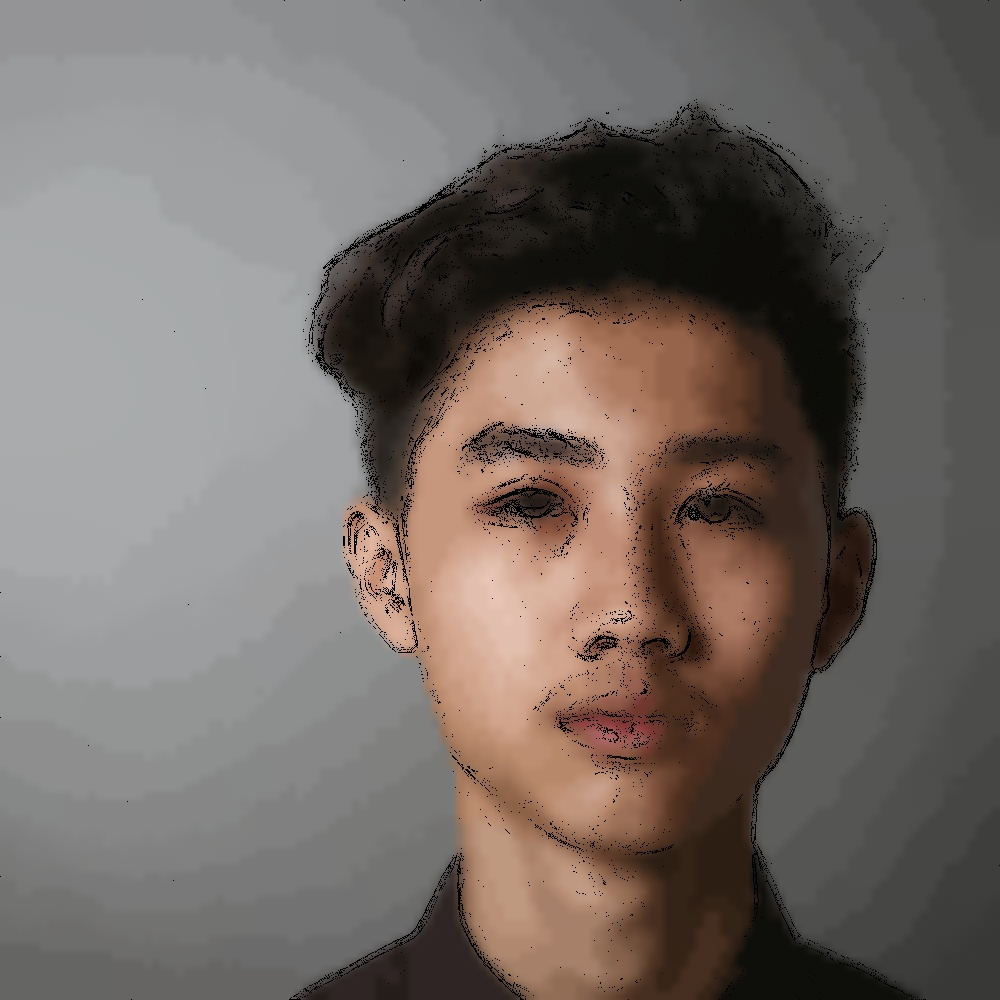

In [ ]:
binary_sketch = cv2.cvtColor(binary_sketch, cv2.COLOR_GRAY2RGB)
background = np.zeros(binary_sketch.shape, dtype=np.uint8)
mask = binary_sketch == 0
background[mask] = cartoon_image[mask]
cv2.imwrite('final_output.jpg', background)

# Display the image
dis('final_output.jpg')

#resize and show input output next to each other

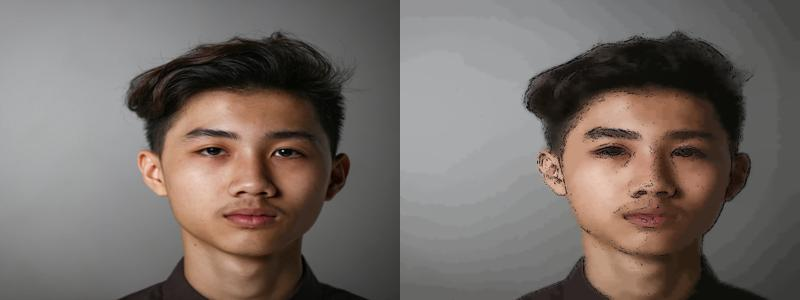

In [ ]:
from PIL import Image

new_width = 400
new_height = 300

# Open the two images
image1 = Image.open("part1.jpg")
image1 = image1.resize((new_width, new_height))

image2 = Image.open("final_output.jpg")
image2 = image2.resize((new_width, new_height))


# Create a new image with the calculated dimensions
merged_image = Image.new("RGB", (2*new_width, new_height))


# Paste the first image on the left side of the merged image
merged_image.paste(image1, (0, 0))

# Paste the second image to the right of the first image
merged_image.paste(image2, (new_width, 0))

merged_image.save("merged_image.jpg")

dis("merged_image.jpg")


# Road Lane Detection Using Hough Transform

# read image

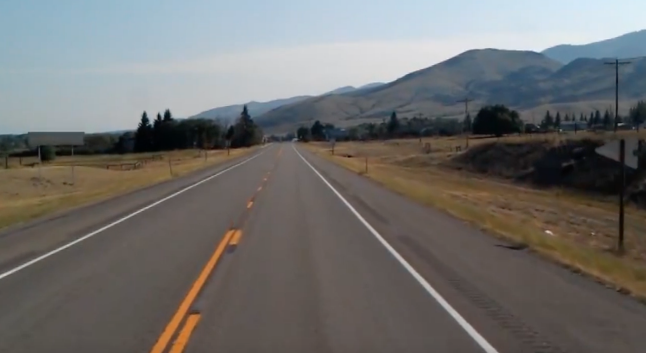

In [ ]:
img = cv2.imread("lane detection.PNG")
cv2_imshow(img)

# Convert image to gray scale to accelerate processing

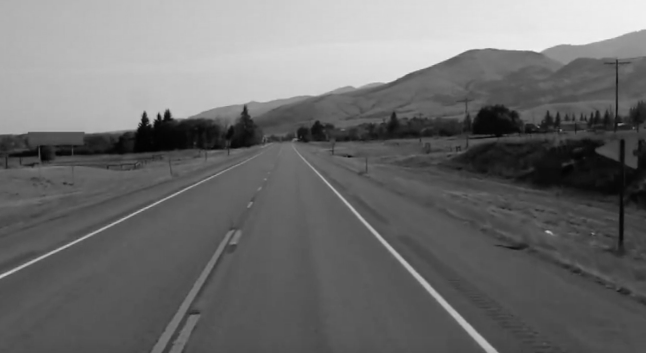

In [ ]:
gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cv2_imshow(gray_image) #to output gray-scale image

# Smoothing the image using a 2-dimensional median smoothing filter


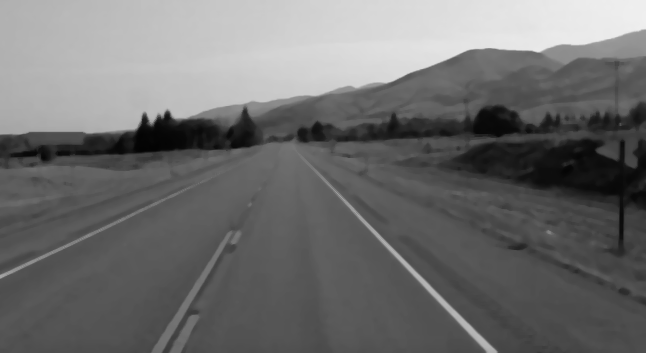

In [ ]:
img_copy = np.copy(gray_image)
smoothed_image = cv2.medianBlur(img_copy,5)
cv2_imshow(smoothed_image)

# Original gray image VS Smoothed image

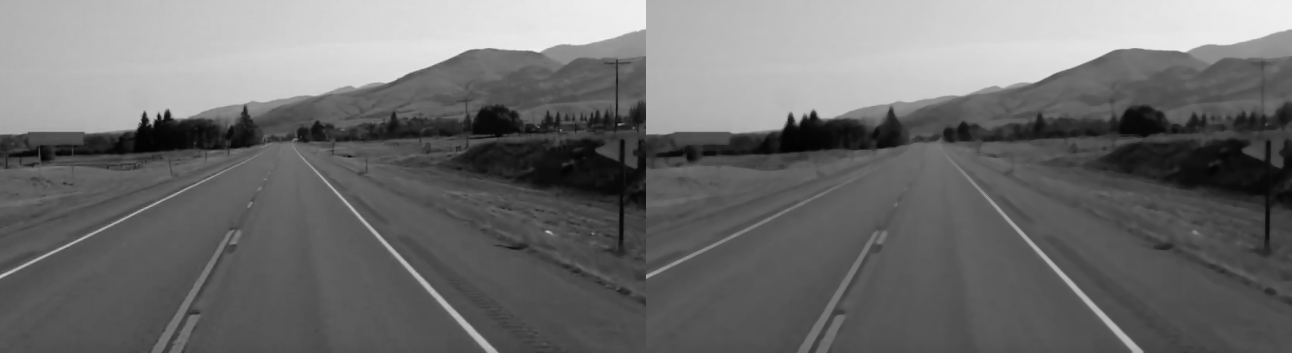

In [ ]:
numpy_vertical = np.hstack((gray_image, smoothed_image))
cv2_imshow(numpy_vertical)

# Edge Detection

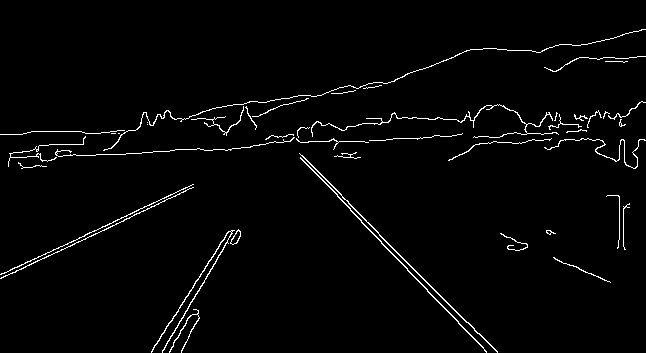

In [ ]:
canny = cv2.Canny(smoothed_image, 50, 150) #to obtain edges of the image
cv2_imshow(canny)

#  Region Of Interest Extraction

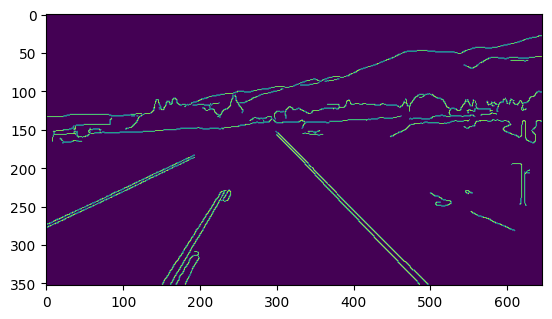

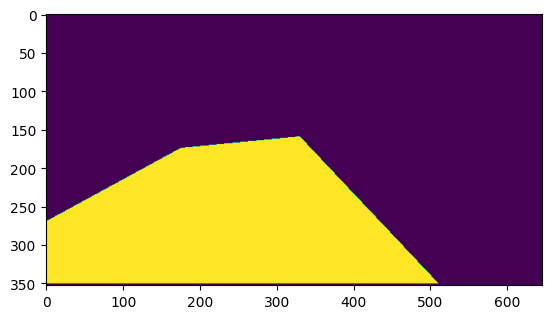

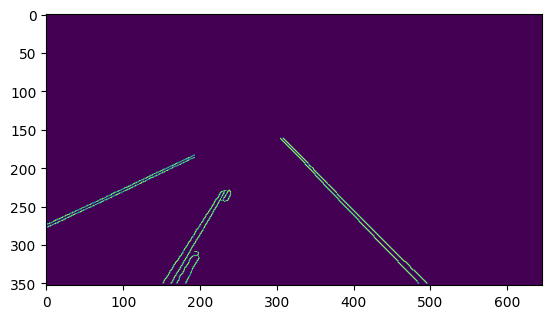

In [ ]:
width, height= smoothed_image.shape
# mask = np.zeros(smoothed_image.shape[:2], dtype="uint8")
# #cv2.rectangle(mask, (0, 90), (290, 450), 255, -1)
# cv2.rectangle(mask, (0, int(0.5*width)), (height, width), 255, -1)
# plt.imshow(mask, cmap='gray')

# edges_masked = cv2.bitwise_and(canny, canny, mask=mask)
# plt.imshow(edges_masked, cmap='gray')
vertices = np.array([[(0, 350), (0, 270), (175, 175),(330, 160), (510, 350)]], dtype=np.int32)
mask = np.zeros_like(canny)
cv2.fillPoly(mask, vertices, 255)
masked_image = cv2.bitwise_and(canny, mask)

# Display the images
plt.imshow(canny)
plt.show()
plt.imshow(mask)
plt.show()
plt.imshow(masked_image)
plt.show()

# Accumulation into (ρ, θ)-space using Hough transform

1.   List item
2.   List item



In [ ]:
def hough_transform_line(img, edge_image, num_rhos=180, num_thetas=180, t_count=350):
    lane_image = np.copy(img)
    edge_height, edge_width = edge_image.shape[:2]

    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos

    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=2)

    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))

    accumulator = np.zeros((len(rhos), len(thetas)))

    for y in range(edge_height):
        for x in range(edge_width):
            if edge_image[y][x] != 0:
                edge_point = [y, x]
                for theta_idx in range(len(thetas)):
                    rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    accumulator[rho_idx][theta_idx] += 1

    for x in range(accumulator.shape[0]):
        for y in range(accumulator.shape[1]):
            if accumulator[x][y] > t_count:
                rho = rhos[x]
                theta = thetas[y]
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                x0 = (a * rho)
                y0 = (b * rho)
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                cv2.line(lane_image, (x1,y1), (x2,y2), (0,255,0), 2, cv2.LINE_AA)

    return lane_image, accumulator

# Plot the accumulator array as an image to show the voting operation result

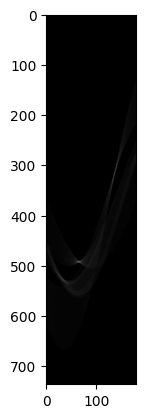

In [ ]:
img_copy, accumulator = hough_transform_line(img, masked_image)
plt.imshow(accumulator, cmap='gray')

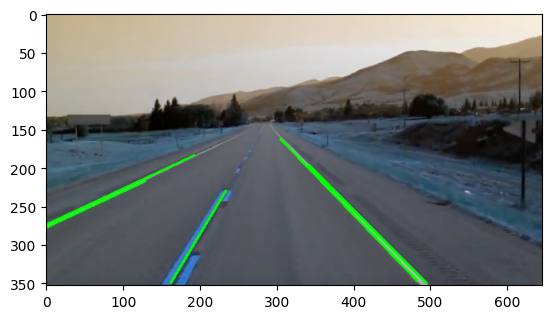

In [ ]:
plt.imshow(img_copy)


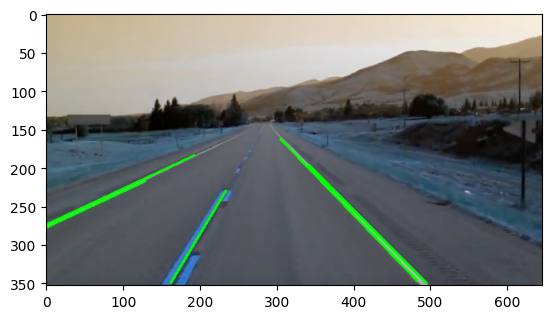

In [ ]:
lines = cv2.HoughLinesP(masked_image, rho=1, theta=np.pi/180, threshold=100, minLineLength=5, maxLineGap=25)

if lines is not None:
    for i in range(len(lines)):
        l = lines[i][0]
        cv2.line(img, (l[0], l[1]), (l[2], l[3]), (0,255,0), 2)

plt.imshow(img)